Design Optimization

1. For this assignment, I have optimized the 4 bar linkage in the salamander robot so that it achieves maximum velocity of the end effector. The reason for doing this is so that the robot becomes more agile and can attain higher speeds. 

In [1]:
%matplotlib inline
use_constraints = True

In [2]:
import pynamics
from pynamics.frame import Frame
from pynamics.variable_types import Differentiable,Constant
from pynamics.system import System
from pynamics.body import Body
from pynamics.dyadic import Dyadic
from pynamics.output import Output,PointsOutput
from pynamics.particle import Particle
from pynamics.constraint import AccelerationConstraint
import pynamics.integration
import numpy
import sympy
import matplotlib.pyplot as plt
plt.ion()
from math import pi
import scipy

In [3]:
system = System()
pynamics.set_system(__name__,system)

In [4]:
lA = Constant(5,'lA',system)
lB = Constant(3,'lB',system)
lC = Constant(3,'lC',system)

In [5]:
mA = Constant(.010,'mA',system)
mB = Constant(.06,'mB',system)
mC = Constant(.06,'mC',system)

g = Constant(9.81,'g',system)
b = Constant(8,'b',system)
k = Constant(8,'k',system)

preload1 = Constant(0*pi/180,'preload1',system)
preload2 = Constant(-90*pi/180,'preload2',system)
preload3 = Constant(-80*pi/180,'preload3',system)

In [6]:
torque = Constant(-20,'torque',system)
freq = Constant(0.05,'freq',system)

qA,qA_d,qA_dd = Differentiable('qA',system)
qB,qB_d,qB_dd = Differentiable('qB',system)
qC,qC_d,qC_dd = Differentiable('qC',system)

In [7]:
initialvalues = {}
initialvalues[qA]=0*pi/180
initialvalues[qA_d]=0*pi/180
initialvalues[qB]=-90*pi/180
initialvalues[qB_d]=0*pi/180
initialvalues[qC]=-80*pi/180
initialvalues[qC_d]=0*pi/180

In [8]:
statevariables = system.get_state_variables()
ini = [initialvalues[item] for item in statevariables]

In [9]:
N = Frame('N',system)
A = Frame('A',system)
B = Frame('B',system)
C = Frame('C',system)

system.set_newtonian(N)

In [10]:
A.rotate_fixed_axis(N,[0,0,1],qA,system)
B.rotate_fixed_axis(A,[0,0,1],qB,system)
C.rotate_fixed_axis(B,[0,0,1],qC,system)

In [11]:
pNA=0*N.x
pAB=pNA+lA*A.x
pBC = pAB + lB*B.x
pCtip = pBC + lC*C.x

wNA = N.get_w_to(A)
wAB = A.get_w_to(B)
wBC = B.get_w_to(C)

In [12]:
vCtip = pCtip.time_derivative(N,system)

Ixx_A = Constant(3.5417e-07,'Ixx_A',system)
Iyy_A = Constant(2.4167e-06,'Iyy_A',system)
Izz_A = Constant(2.1047e-06,'Izz_A',system)
Ixx_B = Constant(3.5417e-07,'Ixx_B',system)
Iyy_B = Constant(1.0833e-06,'Iyy_B',system)
Izz_B = Constant(7.7083e-07,'Izz_B',system)
Ixx_C = Constant(3.5417e-07,'Ixx_C',system)
Iyy_C = Constant(1.0833e-06,'Iyy_C',system)
Izz_C = Constant(7.7083e-07,'Izz_C',system)

In [13]:
IA = Dyadic.build(A,Ixx_A,Iyy_A,Izz_A)
IB = Dyadic.build(B,Ixx_B,Iyy_B,Izz_B)
IC = Dyadic.build(C,Ixx_C,Iyy_C,Izz_C)

pAcm=pNA+lA/2*A.x
pBcm=pAB+lB/2*B.x
pCcm=pBC+lC/2*C.x


In [14]:
BodyA = Body('BodyA',A,pAcm,mA,IA,system)
BodyB = Body('BodyB',B,pBcm,mB,IB,system)
BodyC = Body('BodyC',C,pCcm,mC,IC,system)

In [15]:
p = sympy.Piecewise((0, system.t < 0), (torque, system.t <= 1), (0, True))
# system.addforce(p*A.z,wNA)
system.addforce(torque*sympy.cos(freq*2*sympy.pi*system.t)*A.z,wNA)
system.addforce(-b*wNA,wNA)
system.addforce(-b*wAB,wAB)
system.addforce(-b*wBC,wBC)

In [16]:
system.add_spring_force1(k,(qA-preload1)*N.z,wNA) 
system.add_spring_force1(k,(qB-preload2)*A.z,wAB)
system.add_spring_force1(k,(qC-preload3)*B.z,wBC)

system.addforcegravity(-g*N.y)

In [17]:
if use_constraints:
    eq = []
    eq.append(pCtip)
    eq_d=[item.time_derivative() for item in eq]
    eq_dd=[item.time_derivative() for item in eq_d]
    eq_dd_scalar = []
    eq_dd_scalar.append(eq_dd[0].dot(N.y))
    eq_dd_scalar.append(eq_dd[0].dot(N.x))
    constraint = AccelerationConstraint(eq_dd_scalar)
    system.add_constraint(constraint)

In [18]:
f,ma = system.getdynamics()

2022-04-28 18:50:14,010 - pynamics.system - INFO - getting dynamic equations


In [19]:
points = [pNA, pAB, pBC, pCtip]

In [20]:
func1,lambda1 = system.state_space_post_invert(f,ma,return_lambda = True)

tol = 1e-5

tinitial = 0
tfinal = 10
fps = 30
tstep = 1/fps
t = numpy.r_[tinitial:tfinal:tstep]

2022-04-28 18:50:14,647 - pynamics.system - INFO - solving a = f/m and creating function
2022-04-28 18:50:14,894 - pynamics.system - INFO - substituting constrained in Ma-f.
2022-04-28 18:50:15,336 - pynamics.system - INFO - done solving a = f/m and creating function
2022-04-28 18:50:15,337 - pynamics.system - INFO - calculating function for lambdas


In [21]:
PE = system.getPEGravity(0*N.x)
KE = system.get_KE()

In [22]:
E = KE-PE
E

0.5*Izz_A*qA_d**2 + 0.5*Izz_B*qA_d*(qA_d + qB_d) + 0.5*Izz_B*qB_d*(qA_d + qB_d) + 0.5*Izz_C*qA_d*(qA_d + qB_d + qC_d) + 0.5*Izz_C*qB_d*(qA_d + qB_d + qC_d) + 0.5*Izz_C*qC_d*(qA_d + qB_d + qC_d) + g*lA*mA*sin(qA)/2 + g*lA*mB*sin(qA) + g*lA*mC*sin(qA) + g*lB*mB*sin(qA)*cos(qB)/2 + g*lB*mB*sin(qB)*cos(qA)/2 + g*lB*mC*sin(qA)*cos(qB) + g*lB*mC*sin(qB)*cos(qA) + g*lC*mC*(-sin(qB)*sin(qC) + cos(qB)*cos(qC))*sin(qA)/2 + g*lC*mC*(sin(qB)*cos(qC) + sin(qC)*cos(qB))*cos(qA)/2 + 0.125*lA**2*mA*qA_d**2 + 0.5*mB*(lA**2*qA_d**2 + lA*lB*qA_d*(qA_d + qB_d)*cos(qB) + lB**2*(qA_d + qB_d)**2/4) + 0.5*mC*(lA**2*qA_d**2 + 2*lA*lB*qA_d*(qA_d + qB_d)*cos(qB) - lA*lC*qA_d*(qA_d + qB_d + qC_d)*sin(qB)*sin(qC) + lA*lC*qA_d*(qA_d + qB_d + qC_d)*cos(qB)*cos(qC) + lB**2*(qA_d + qB_d)**2 + lB*lC*(qA_d + qB_d)*(qA_d + qB_d + qC_d)*cos(qC) + lC**2*(qA_d + qB_d + qC_d)**2/4)

In [23]:
PE

-g*lA*mA*sin(qA)/2 - g*lA*mB*sin(qA) - g*lA*mC*sin(qA) - g*lB*mB*sin(qA)*cos(qB)/2 - g*lB*mB*sin(qB)*cos(qA)/2 - g*lB*mC*sin(qA)*cos(qB) - g*lB*mC*sin(qB)*cos(qA) - g*lC*mC*(-sin(qB)*sin(qC) + cos(qB)*cos(qC))*sin(qA)/2 - g*lC*mC*(sin(qB)*cos(qC) + sin(qC)*cos(qB))*cos(qA)/2

2. After defining the system, I have decided to change the length of link 1 i.e lA, and see which value of lA gives the maximum end effector velocity (Vb). I have changed the values of lA between 0.1  to 10. In order to minimize the function, I am considering 1/(end effector velocity) to be my minimizing function.


In [24]:
def run(args):
    my_link = args[0]
    constants = system.constant_values.copy()
    constants[lA] = my_link    
    states=pynamics.integration.integrate_odeint(func1,ini,t, args=({'constants':constants},)) 
    return states

In [25]:
def measure_perf(args):
    print('r: ',args[0])
   # if args[0]>1:
   #     return 1000
   # if args[0]<=0:
   #     return 1000
    try:
        states = run(args)
        # perf = lA*qA_d*A.y 
        perf = 1/(args[0] * states[-1,3] + system.constant_values[lB] * (states[-1,3] + states[-1,4]) + system.constant_values[lC] * (states[-1,3] + states[-1,4] + states[-1,5])) 
            # + lB*(states[-1,3]+states[-1,4]) + lC*(states[-1,3]+states[-1,4]+states[-1,5])
        # perf = (1/states[-1,0])**2 + 5*(states[-1,1])**2 
        return perf
    except scipy.linalg.LinAlgError:
        return 1000

r:  0.1


2022-04-28 18:50:15,721 - pynamics.integration - INFO - beginning integration
2022-04-28 18:50:15,722 - pynamics.system - INFO - integration at time 0000.00
2022-04-28 18:50:16,556 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:16,558 - pynamics.integration - INFO - beginning integration
2022-04-28 18:50:16,722 - pynamics.system - INFO - integration at time 0000.09


r:  1.2000000000000002


2022-04-28 18:50:17,286 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:17,287 - pynamics.integration - INFO - beginning integration


r:  2.3000000000000003


2022-04-28 18:50:17,690 - pynamics.system - INFO - integration at time 0001.54
2022-04-28 18:50:17,915 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:17,917 - pynamics.integration - INFO - beginning integration


r:  3.4000000000000004


2022-04-28 18:50:18,426 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:18,428 - pynamics.integration - INFO - beginning integration


r:  4.5


2022-04-28 18:50:18,659 - pynamics.system - INFO - integration at time 0001.58
2022-04-28 18:50:19,235 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:19,237 - pynamics.integration - INFO - beginning integration


r:  5.6


2022-04-28 18:50:19,642 - pynamics.system - INFO - integration at time 0005.30
2022-04-28 18:50:20,121 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:20,122 - pynamics.integration - INFO - beginning integration


r:  6.7


2022-04-28 18:50:20,585 - pynamics.system - INFO - integration at time 0005.41
2022-04-28 18:50:20,990 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:20,991 - pynamics.integration - INFO - beginning integration


r:  7.800000000000001


2022-04-28 18:50:21,560 - pynamics.system - INFO - integration at time 0006.39
2022-04-28 18:50:21,839 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:21,840 - pynamics.integration - INFO - beginning integration


r:  8.9


2022-04-28 18:50:22,559 - pynamics.system - INFO - integration at time 0008.65
2022-04-28 18:50:22,674 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:22,676 - pynamics.integration - INFO - beginning integration


r:  10.0


2022-04-28 18:50:23,451 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:23,492 - pynamics.integration - INFO - beginning integration
2022-04-28 18:50:23,593 - pynamics.system - INFO - integration at time 0000.01


r:  0.5


2022-04-28 18:50:24,503 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:24,505 - pynamics.integration - INFO - beginning integration
2022-04-28 18:50:24,576 - pynamics.system - INFO - integration at time 0000.08


r:  3.8814635113760407


2022-04-28 18:50:24,947 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:24,948 - pynamics.integration - INFO - beginning integration


r:  6.2185364886239585


2022-04-28 18:50:25,530 - pynamics.system - INFO - integration at time 0006.70
2022-04-28 18:50:25,886 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:25,887 - pynamics.integration - INFO - beginning integration


r:  2.437072977247918


2022-04-28 18:50:26,438 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:26,440 - pynamics.integration - INFO - beginning integration
2022-04-28 18:50:26,486 - pynamics.system - INFO - integration at time 0000.00


r:  1.544390534128123


2022-04-28 18:50:27,103 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:27,104 - pynamics.integration - INFO - beginning integration


r:  0.9926824431197951


2022-04-28 18:50:27,426 - pynamics.system - INFO - integration at time 0000.37
2022-04-28 18:50:27,869 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:27,871 - pynamics.integration - INFO - beginning integration


r:  1.6490256649613366


2022-04-28 18:50:28,371 - pynamics.system - INFO - integration at time 0003.49
2022-04-28 18:50:28,545 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:28,547 - pynamics.integration - INFO - beginning integration


r:  1.7015358716351372


2022-04-28 18:50:29,129 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:29,130 - pynamics.integration - INFO - beginning integration
2022-04-28 18:50:29,334 - pynamics.system - INFO - integration at time 0000.32


r:  1.6889797516401128


2022-04-28 18:50:29,794 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:29,797 - pynamics.integration - INFO - beginning integration


r:  1.6878861072163596


2022-04-28 18:50:30,293 - pynamics.system - INFO - integration at time 0002.64
2022-04-28 18:50:30,479 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:30,481 - pynamics.integration - INFO - beginning integration


r:  1.6877720883147995


2022-04-28 18:50:31,124 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:31,125 - pynamics.integration - INFO - beginning integration
2022-04-28 18:50:31,269 - pynamics.system - INFO - integration at time 0000.11


r:  1.6881881823990874


2022-04-28 18:50:31,827 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:31,828 - pynamics.integration - INFO - beginning integration


r:  1.6879194581688912


2022-04-28 18:50:32,240 - pynamics.system - INFO - integration at time 0002.07
2022-04-28 18:50:32,483 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:32,485 - pynamics.integration - INFO - beginning integration


r:  1.687852756263828


2022-04-28 18:50:33,159 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:33,161 - pynamics.integration - INFO - beginning integration
2022-04-28 18:50:33,220 - pynamics.system - INFO - integration at time 0000.03


r:  2.875772214432719


2022-04-28 18:50:33,875 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:33,877 - pynamics.integration - INFO - beginning integration


r:  3.8814635113760407


2022-04-28 18:50:34,190 - pynamics.system - INFO - integration at time 0002.77
2022-04-28 18:50:34,316 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:34,317 - pynamics.integration - INFO - beginning integration


r:  6.218536488623959


2022-04-28 18:50:35,156 - pynamics.system - INFO - integration at time 0009.27
2022-04-28 18:50:35,267 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:35,268 - pynamics.integration - INFO - beginning integration


r:  2.4370729772479183


2022-04-28 18:50:35,811 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:35,813 - pynamics.integration - INFO - beginning integration


r:  1.5443905341281234


2022-04-28 18:50:36,118 - pynamics.system - INFO - integration at time 0000.59
2022-04-28 18:50:36,532 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:36,534 - pynamics.integration - INFO - beginning integration


r:  0.9926824431197953


2022-04-28 18:50:37,112 - pynamics.system - INFO - integration at time 0003.45
2022-04-28 18:50:37,312 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:37,314 - pynamics.integration - INFO - beginning integration


r:  1.649026831226292


2022-04-28 18:50:38,003 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:38,005 - pynamics.integration - INFO - beginning integration
2022-04-28 18:50:38,077 - pynamics.system - INFO - integration at time 0000.02


r:  1.7015306274204764


2022-04-28 18:50:38,614 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:38,616 - pynamics.integration - INFO - beginning integration


r:  1.688985950734405


2022-04-28 18:50:39,043 - pynamics.system - INFO - integration at time 0001.35
2022-04-28 18:50:39,250 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:39,251 - pynamics.integration - INFO - beginning integration


r:  1.6878681000562328


2022-04-28 18:50:39,874 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:39,875 - pynamics.integration - INFO - beginning integration
2022-04-28 18:50:40,022 - pynamics.system - INFO - integration at time 0000.12


r:  1.6884960187180325


2022-04-28 18:50:40,593 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:40,595 - pynamics.integration - INFO - beginning integration


r:  1.6937775908506059


2022-04-28 18:50:40,996 - pynamics.system - INFO - integration at time 0001.00
2022-04-28 18:50:41,316 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:41,318 - pynamics.integration - INFO - beginning integration


r:  1.6908161943969362


2022-04-28 18:50:41,991 - pynamics.system - INFO - integration at time 0008.08
2022-04-28 18:50:42,090 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:42,092 - pynamics.integration - INFO - beginning integration


r:  1.6896850416057978


2022-04-28 18:50:42,691 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:42,693 - pynamics.integration - INFO - beginning integration


r:  1.6892529796860523


2022-04-28 18:50:43,004 - pynamics.system - INFO - integration at time 0000.65
2022-04-28 18:50:43,327 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:43,328 - pynamics.integration - INFO - beginning integration


r:  1.6887988133563274


2022-04-28 18:50:43,890 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:43,892 - pynamics.integration - INFO - beginning integration
2022-04-28 18:50:44,020 - pynamics.system - INFO - integration at time 0000.06


r:  1.6890879467179538


2022-04-28 18:50:44,490 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:44,492 - pynamics.integration - INFO - beginning integration


r:  1.6889144706165449


2022-04-28 18:50:45,050 - pynamics.system - INFO - integration at time 0006.21
2022-04-28 18:50:45,181 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:45,183 - pynamics.integration - INFO - beginning integration


r:  1.689025546954292


2022-04-28 18:50:45,962 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:45,963 - pynamics.integration - INFO - beginning integration
2022-04-28 18:50:46,067 - pynamics.system - INFO - integration at time 0000.18


r:  3.8814635113760403


2022-04-28 18:50:46,440 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:46,441 - pynamics.integration - INFO - beginning integration


r:  6.218536488623958


2022-04-28 18:50:47,058 - pynamics.system - INFO - integration at time 0007.35
2022-04-28 18:50:47,386 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:47,388 - pynamics.integration - INFO - beginning integration


r:  2.437072977247918


2022-04-28 18:50:47,939 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:47,941 - pynamics.integration - INFO - beginning integration
2022-04-28 18:50:48,037 - pynamics.system - INFO - integration at time 0000.02


r:  1.544390534128123


2022-04-28 18:50:48,655 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:48,657 - pynamics.integration - INFO - beginning integration


r:  0.9926824431197951


2022-04-28 18:50:49,021 - pynamics.system - INFO - integration at time 0000.44
2022-04-28 18:50:49,427 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:49,429 - pynamics.integration - INFO - beginning integration


r:  1.6490256649613366


2022-04-28 18:50:49,989 - pynamics.system - INFO - integration at time 0005.88
2022-04-28 18:50:50,112 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:50,113 - pynamics.integration - INFO - beginning integration


r:  1.7015358716351374


2022-04-28 18:50:50,761 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:50,762 - pynamics.integration - INFO - beginning integration


r:  1.6889797609385078


2022-04-28 18:50:51,011 - pynamics.system - INFO - integration at time 0000.46
2022-04-28 18:50:51,575 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:51,576 - pynamics.integration - INFO - beginning integration


r:  1.6878825639865689


2022-04-28 18:50:52,043 - pynamics.system - INFO - integration at time 0002.90
2022-04-28 18:50:52,296 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:52,297 - pynamics.integration - INFO - beginning integration


r:  1.6882507313032786


2022-04-28 18:50:52,894 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:52,895 - pynamics.integration - INFO - beginning integration
2022-04-28 18:50:53,050 - pynamics.system - INFO - integration at time 0000.10


r:  1.6883294046725963


2022-04-28 18:50:53,591 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:53,593 - pynamics.integration - INFO - beginning integration


r:  1.6881271181027617


2022-04-28 18:50:54,066 - pynamics.system - INFO - integration at time 0001.51
2022-04-28 18:50:54,280 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:54,281 - pynamics.integration - INFO - beginning integration


r:  1.688033706742465


2022-04-28 18:50:55,038 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:55,040 - pynamics.integration - INFO - beginning integration
2022-04-28 18:50:55,058 - pynamics.system - INFO - integration at time 0000.00


r:  1.6881472916451163


2022-04-28 18:50:55,720 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:55,722 - pynamics.integration - INFO - beginning integration


r:  1.6880914381380636


2022-04-28 18:50:56,055 - pynamics.system - INFO - integration at time 0000.93
2022-04-28 18:50:56,413 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:56,415 - pynamics.integration - INFO - beginning integration


r:  1.6881134895689645


2022-04-28 18:50:57,020 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:57,022 - pynamics.integration - INFO - beginning integration
2022-04-28 18:50:57,059 - pynamics.system - INFO - integration at time 0000.00


r:  1.6881348237102678


2022-04-28 18:50:57,781 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:57,783 - pynamics.integration - INFO - beginning integration


r:  1.6881237377354072


2022-04-28 18:50:58,000 - pynamics.system - INFO - integration at time 0000.39
2022-04-28 18:50:58,507 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:58,509 - pynamics.integration - INFO - beginning integration


r:  1.688127154776951


2022-04-28 18:50:58,935 - pynamics.system - INFO - integration at time 0001.73
2022-04-28 18:50:59,216 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:59,217 - pynamics.integration - INFO - beginning integration


r:  1.6881258269173267


2022-04-28 18:50:59,903 - pynamics.system - INFO - integration at time 0007.80
2022-04-28 18:50:59,977 - pynamics.integration - INFO - finished integration
2022-04-28 18:50:59,979 - pynamics.integration - INFO - beginning integration


r:  1.6881266249138114


2022-04-28 18:51:00,686 - pynamics.integration - INFO - finished integration
2022-04-28 18:51:00,687 - pynamics.integration - INFO - beginning integration
2022-04-28 18:51:00,865 - pynamics.system - INFO - integration at time 0000.19


r:  1.6881269297213455


2022-04-28 18:51:01,301 - pynamics.integration - INFO - finished integration
2022-04-28 18:51:01,302 - pynamics.integration - INFO - beginning integration


r:  1.6881270461474636


2022-04-28 18:51:01,820 - pynamics.system - INFO - integration at time 0004.46
2022-04-28 18:51:02,008 - pynamics.integration - INFO - finished integration
2022-04-28 18:51:02,010 - pynamics.integration - INFO - beginning integration


r:  1.6881270016766436


2022-04-28 18:51:02,743 - pynamics.integration - INFO - finished integration


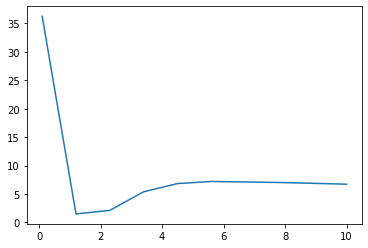

In [26]:
yy = []    
xx = numpy.r_[0.1:10:10j]
for ii in xx:
    yy.append(measure_perf([ii]))
    
yy = numpy.array(yy)
plt.plot(xx,yy)

result = scipy.optimize.minimize(measure_perf,[.5],method='powell',bounds=[(.1,10)])
best = result.x

In [27]:
best

array([1.68812705])

3. Therefore scipy returns a link length value of 1.63 for which maximum end effector velocity is achieved.

In [28]:
states = run([best])

2022-04-28 18:51:02,947 - pynamics.integration - INFO - beginning integration
<lambdifygenerated-1>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array([[Izz_A + Izz_B + Izz_C + (1/4)*lA**2*mA + lA**2*mB + lA**2*mC + lA*lB*mB*cos(qB) + 2*lA*lB*mC*cos(qB) - lA*lC*mC*sin(qB)*sin(qC) + lA*lC*mC*cos(qB)*cos(qC) + (1/4)*lB**2*mB + lB**2*mC + lB*lC*mC*cos(qC) + (1/4)*lC**2*mC, Izz_B + Izz_C + (1/2)*lA*lB*mB*cos(qB) + lA*lB*mC*cos(qB) - 1/2*lA*lC*mC*sin(qB)*sin(qC) + (1/2)*lA*lC*mC*cos(qB)*cos(qC) + (1/4)*lB**2*mB + lB**2*mC + lB*lC*mC*cos(qC) + (1/4)*lC**2*mC, Izz_C - 1/2*lA*lC*mC*sin(qB)*sin(qC) + (1/2)*lA*lC*mC*cos(qB)*cos(qC) + (1/2)*lB*lC*mC*cos(qC) + (1/4)*lC**2*mC, lA*cos(qA) - lB*sin(qA)*sin(qB) + lB*cos(qA)*cos(qB) + lC*(-sin(qA)*sin(qB) + cos(qA)*cos(qB))

2022-04-28 18:51:04,227 - pynamics.output - INFO - calculating outputs
2022-04-28 18:51:04,253 - pynamics.output - INFO - done calculating outputs


<AxesSubplot:>

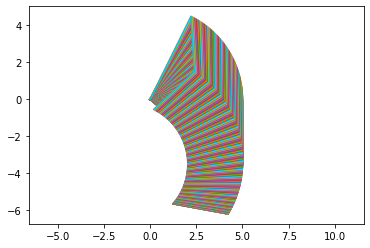

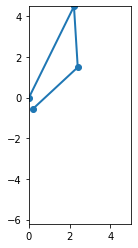

In [29]:
po = PointsOutput(points,system)
po.calc(states,t)
po.plot_time()
po.animate(fps = 30, movie_name='4_bar_mechanism.mp4',lw=2,marker='o')

4. So this way, we have been able to converge towards the optimal link length using scipy minimize function.